### Factors for immigration
 
 I'll identify the factors on which immigration depends the most. Will try to identify correlation variables for each 

In [12]:
import pandas as pd
import pprint
import csv
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.preprocessing import StandardScaler

In [2]:
# read the csv filtered file which has only the features
# corelated to immigration
file_name = "Euro_Perc_Immi.csv"
df_percimmi = pd.read_csv(file_name)
pprint.pprint(df_percimmi.head())

        GEO  Perc_immi  X2018.Mean.fertility.age  X2018.fertility.rate  \
0   Austria   0.011801                      29.5                  1.47   
1   Belgium   0.011545                      29.0                  1.62   
2  Bulgaria   0.003284                      26.2                  1.56   
3   Croatia   0.003136                      28.8                  1.47   
4    Cyprus   0.020891                      29.8                  1.32   

   Divorce.rate  Divorce.percentage  Median.age  Old.Young.ratio  \
0           1.8                36.0        43.2             27.9   
1           2.0                52.0        41.6             29.1   
2           1.5                36.4        44.1             32.5   
3           1.5                30.8        43.7             30.7   
4           2.2                32.8        37.5             23.4   

   Child.Adult.ratio  Life.Expectancy  X2019.Educated  Unit_GDP  Unit_divorce  
0               34.9             81.8            42.4  0.037560   

In [3]:
# Lets get the corelation matrix and print it out
# Remove the GEO column from the dataframe
df_pi_rmgeo = df_percimmi.drop(columns=['GEO'])
# pprint.pprint(df_pi_rmgeo.head())
corr_m = df_pi_rmgeo.corr()
pprint.pprint(corr_m)

                          Perc_immi  X2018.Mean.fertility.age  \
Perc_immi                  1.000000                  0.449169   
X2018.Mean.fertility.age   0.449169                  1.000000   
X2018.fertility.rate      -0.240712                 -0.422023   
Divorce.rate              -0.201176                 -0.093717   
Divorce.percentage        -0.052126                  0.418376   
Median.age                -0.507439                  0.036907   
Old.Young.ratio           -0.579784                  0.005454   
Child.Adult.ratio          0.038727                  0.055458   
Life.Expectancy            0.515809                  0.845510   
X2019.Educated             0.484194                  0.295436   
Unit_GDP                   0.530134                  0.624038   
Unit_divorce              -0.225795                 -0.102470   

                          X2018.fertility.rate  Divorce.rate  \
Perc_immi                            -0.240712     -0.201176   
X2018.Mean.fertility.age  

## Steps to drop irrelevant variables
1. Remove features that are not highly corelated to 'percentage immigration'
2. Check if any of the remaining variables are corelated to each other, and remove the one that is less corelated to 'percentage immigration'
3. View scatterplot to confirm the remaining features are corelated to 'Percentage Immigration'

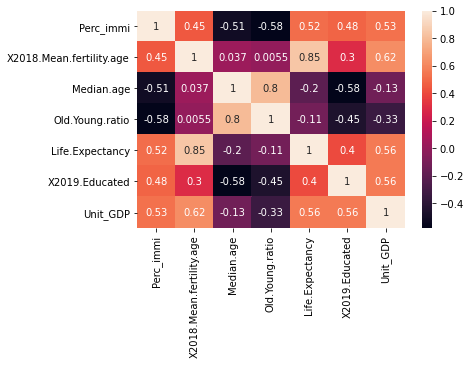

In [4]:
# Lets drop the features that have a corelation value of less than 0.5
# Dropping Fertility rate, Divorce rate, Divorce percentage,
# Child.Adult ratio and Unit Divorce features

df_cor1 = df_pi_rmgeo.drop(columns=["X2018.fertility.rate",
                                    "Divorce.rate",
                                    "Divorce.percentage",
                                    "Child.Adult.ratio",
                                    "Unit_divorce"])
# pprint.pprint(df_cor1.head())
# Will create and print the corelation matrix again
corr_m = df_cor1.corr()
# pprint.pprint(corr_m)

# may be easier to view this in a heat map
sn.heatmap(corr_m, annot=True)
plt.show()

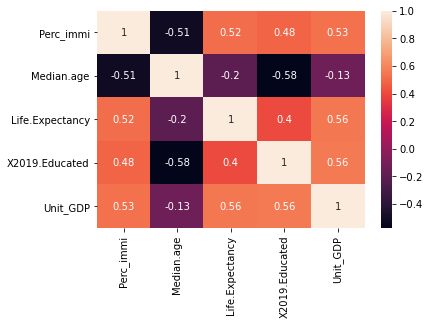

In [5]:
# The heat map shows a strong corelation between following pair of features
# 1. Fertility age and Life Expectancy - 0.85
# 2. Fertilty age and Unit GDP - 0.62
# 3. Median age and Old to Young ratio.
# Lets drop the features 'Fertility Age' and 'Old to Young Ratio'
# Then lets replot the matrix

df_cor2 = df_cor1.drop(columns=['X2018.Mean.fertility.age', 'Old.Young.ratio'])
corr_m2 = df_cor2.corr()

sn.heatmap(corr_m2, annot=True)
plt.show()

## Matrix results

The map shows the resulting features that 'Percentage immigration' depends on.
They are Unit GDP, Life Expectancy, Percentage of graduates and inversely to median age.
Unit GDP is corelated to Life Expectancy and Percentage of graduates. We could 
drop those features later, but will now let remain.

## Linear regression

Lets try creating a linear regression model and logistic regression model using these 
features and check the accuracy


In [6]:
# Removing NA values from the dataframes before applying linear regression
df_cor2 = df_cor2.dropna(axis='index', how='any')

In [7]:
lr = LinearRegression()
reg_y = df_cor2.iloc[:, 0]
reg_x = df_cor2.iloc[:, 1:5]
pprint.pprint(reg_y.head())
pprint.pprint(reg_x.head())
lr.fit(reg_x, reg_y)
pprint.pprint(lr.coef_)
pprint.pprint(lr.intercept_)

0    0.011801
1    0.011545
2    0.003284
3    0.003136
4    0.020891
Name: Perc_immi, dtype: float64
   Median.age  Life.Expectancy  X2019.Educated  Unit_GDP
0        43.2             81.8            42.4  0.037560
1        41.6             81.7            47.5  0.035093
2        44.1             75.0            32.5  0.006374
3        43.7             78.2            33.1  0.011235
4        37.5             82.9            58.8  0.021762
array([-1.14415731e-03,  4.45524249e-04, -1.25195611e-05,  1.56383513e-01])
0.018166639880432732


# Testing

Lets test by using Kfold to split the data and test check the accuracy - r2 value
for the different sets of data


In [8]:
# Create a function to create test and training sets using Kfold
def KFoldTest(x_df, y_df, type='LR') :
    norm_scale = StandardScaler()
    norm_x = norm_scale.fit_transform(x_df)
    norm_x.shape = x_df.shape
    norm_x_frame = pd.DataFrame(data=norm_x, columns=x_df.columns)

    Kf = KFold(n_splits=7, shuffle=True)
    score_arr = []
    for train_indices, test_indices in Kf.split(x_df, y_df) :
        train_x_df = norm_x_frame.iloc[train_indices]
        train_y_df = y_df.iloc[train_indices]
        test_x_df = norm_x_frame.iloc[test_indices]
        test_y_df = y_df.iloc[test_indices]
    
    # Create a linear regression on the training data. 
    # Will test it on the test data.
        if type == 'LS' :
            test_lr = Lasso()
        elif type == 'DTC' :
            test_lr = DecisionTreeClassifier()
        elif type == 'NB' :
            test_lr = GaussianNB()
        else :
            test_lr = LinearRegression()
# pprint.pprint(train_x_df.head())
# pprint.pprint(train_y_df.head())
        test_lr.fit(train_x_df, train_y_df)
        score_arr.append(test_lr.score(test_x_df, test_y_df))
        
    return (score_arr)

In [9]:
# Call the KFold test
pprint.pprint("Normalized matrix")
pprint.pprint(reg_x.head())
scores_lr = KFoldTest(reg_x, reg_y)

# Lets drop columns Life Expectancy and Percentage of graduates.
# Want to check if that results in more consistent results

reg_x2 = reg_x.loc[:, ['Median.age', 'Unit_GDP']]

# Call the KFold test for the new frame

scores_lr2 = KFoldTest(reg_x2, reg_y)

print(scores_lr)
print(scores_lr2)

'Normalized matrix'
   Median.age  Life.Expectancy  X2019.Educated  Unit_GDP
0        43.2             81.8            42.4  0.037560
1        41.6             81.7            47.5  0.035093
2        44.1             75.0            32.5  0.006374
3        43.7             78.2            33.1  0.011235
4        37.5             82.9            58.8  0.021762
[-0.060622425616631004, 0.356098656702757, -1.3087068148146939, 0.786762295752472, 0.20716411955931568, 0.38465026443214356, -8.471307337953375]
[-1.2803995056335356, 0.1915722106184372, -2.1340459397837215, -0.09228467680623043, 0.6182730209822025, 0.4869040111185289, -0.3986005966117352]


In [10]:
# The results after dropping these two variables are not very different.
# Lets check the success of 2 other algorithms for this data

# First we multiply y by 100000 for logistic regression to work
# Also we change y to int.

reg_y = reg_y * 100000
reg_y = reg_y.astype(int)

scores_nb = KFoldTest(reg_x, reg_y, type='LS')
print("Lasso Regression", scores_nb)

# scores_dtc = KFoldTest(reg_x, reg_y, type='NB')
# print("Gaussian NB", scores_dtc)

Lasso Regression [-0.743827270082134, 0.29396658398695563, -3.7238086434060342, 0.7394094894827616, -0.06911697620575441, -0.3549285110731464, -1.5328092679272163]


## Analysis

Since regression values do not provide the required accuracy over all tries
will step back and check if other methods provide a better choice of features 
to work with.

In [11]:
# Removing NA values from the dataframes before applying linear regression
df_percimmi = df_percimmi.dropna(axis='index', how='any')

# Run the SelectKBest function to get the best parameters
best_3 = SelectKBest(f_regression, k=11)
cnd_best_x = df_percimmi.iloc[:, 2:13]
cnd_best_y = df_percimmi.iloc[:, 1]
# pprint.pprint(cnd_best_x.head())
# pprint.pprint(cnd_best_y.head())
best_3.fit(cnd_best_x, cnd_best_y)
bool_mask = best_3.get_support()
# pprint.pprint(bool_mask)
params = best_3.scores_
pprint.pprint(params)
best_x = cnd_best_x.loc[:, bool_mask]
pprint.pprint(best_x.head())

array([7.07927412e+00, 2.91093038e+00, 1.01581449e+00, 6.53875766e-02,
       1.17900452e+01, 1.00311458e+01, 1.09314052e-02, 8.54551993e+00,
       7.15693176e+00, 1.54851769e+01, 1.29677275e+00])
   X2018.Mean.fertility.age  X2018.fertility.rate  Divorce.rate  \
0                      29.5                  1.47           1.8   
1                      29.0                  1.62           2.0   
2                      26.2                  1.56           1.5   
3                      28.8                  1.47           1.5   
4                      29.8                  1.32           2.2   

   Divorce.percentage  Median.age  Old.Young.ratio  Child.Adult.ratio  \
0                36.0        43.2             27.9               34.9   
1                52.0        41.6             29.1               42.7   
2                36.4        44.1             32.5               35.0   
3                30.8        43.7             30.7               37.2   
4                32.8        37.5 

# Comment
The results obtained by using SelectKBest are the same as those obtained by using corelation.
The immigration factors are relevant. However, linear regression does not provide accurate results.
Also, regression is not needed, since the goal was to identify features relevant to immigration.

Checking scores from SelectKBest, the relevant top 6 features in order of priority are
1. Unit GDP
2. Median Age
3. Old to young ratio
4. Life Expectancy
5. Education - Percentage of graduates
6. Mean Fertility age